# Importing Libraries

In [ ]:
%matplotlib inline
from glob import glob
import cv2
import PIL
import tqdm
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import datasets
from skimage.filters import gabor
from skimage.feature import local_binary_pattern, greycomatrix, greycoprops

#Mounting Drive with Images#

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/semester_projects/Machine Learning/Dataset/

/content/drive/.shortcut-targets-by-id/1KWxsKIHsfr4Jg0ERoTDt4kBW08DTNbnF/semester_projects/Machine Learning/Dataset


#Loading Image Files#

In [ ]:
#define size to which images are to be resized
IMAGE_SIZE = [200, 200] # feel free to change depending on dataset

# training config:
epochs = 500
batch_size = 32

#define paths
covid_path = 'COVID'
noncovid_path = 'non-COVID'

# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

In [ ]:
print("First 5 Covid Files: ",covid_files[0:5])
print("Total Count: ",len(covid_files))
print("First 5 NonCovid Files: ",noncovid_files[0:5])
print("Total Count: ",len(noncovid_files))

First 5 Covid Files:  ['COVID/Covid (229).png', 'COVID/Covid (237).png', 'COVID/Covid (1251).png', 'COVID/Covid (182).png', 'COVID/Covid (262).png']
Total Count:  1252
First 5 NonCovid Files:  ['non-COVID/Non-Covid (1161).png', 'non-COVID/Non-Covid (1103).png', 'non-COVID/Non-Covid (1027).png', 'non-COVID/Non-Covid (1038).png', 'non-COVID/Non-Covid (123).png']
Total Count:  1229


In [ ]:
#lables generation
covid_labels = []
noncovid_labels = []
for i in range(len(covid_files)):
  covid_labels.append("covid")
for i in range(len(covid_files)):
  noncovid_labels.append("noncovid")

In [ ]:
files = covid_files + noncovid_files
lables = covid_labels + noncovid_labels
df = pd.DataFrame(list(zip(files, lables)),columns =['Files', 'Lables'])
df = df.sample(frac=1, random_state=42) #shuffle dataset

In [ ]:
df.head()

,Files,Lables
254,COVID/Covid (321).png,covid
621,COVID/Covid (587).png,covid
1730,non-COVID/Non-Covid (638).png,noncovid
1792,non-COVID/Non-Covid (594).png,noncovid
819,COVID/Covid (811).png,covid


COVID/Covid (229).png


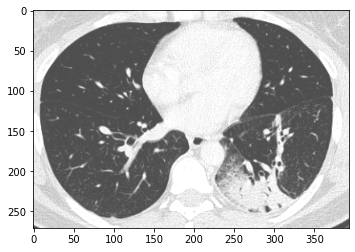

In [ ]:
print(df["Files"][0])
image = cv2.imread(df["Files"][0])
plt.imshow(image)

COVID/Covid (229).png


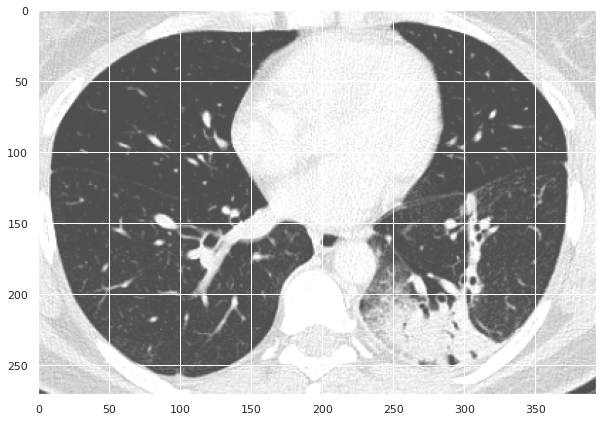

In [ ]:
# Resizing
import cv2
import matplotlib.pyplot as plt
IMAGE_SIZE = [200, 200]

print(df["Files"][0])
image = cv2.imread(df["Files"][0])
plt.imshow(image)

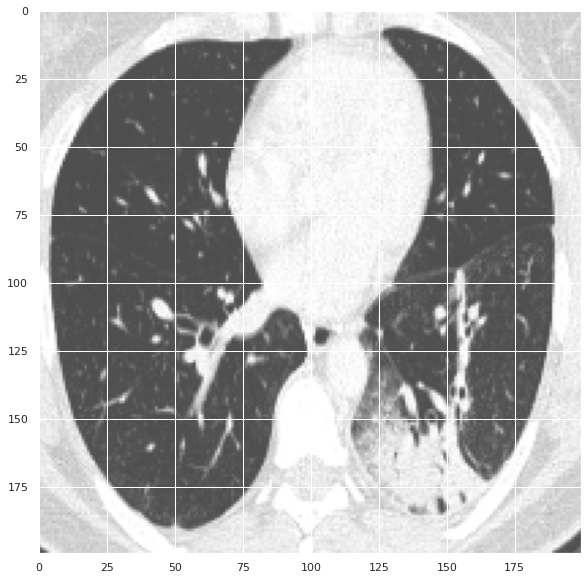

In [ ]:
image = cv2.resize(image,(IMAGE_SIZE[0],IMAGE_SIZE[1]))
plt.imshow(image)

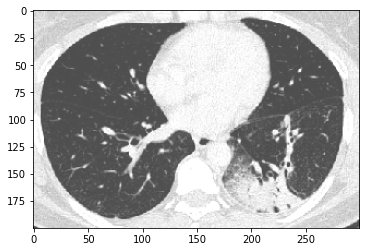

In [ ]:
# Interpolation 
image = cv2.imread(df["Files"][0])
image = cv2.resize(image,(300,200),interpolation=cv2.INTER_NEAREST)
plt.imshow(image)

COVID/Covid (229).png


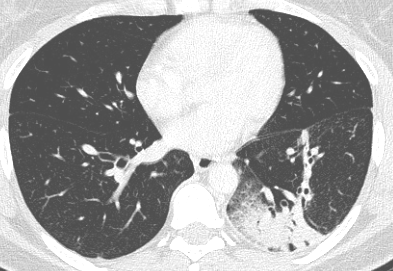

In [ ]:
# Converting to grayscale
from google.colab.patches import cv2_imshow
print(df["Files"][0])
image = cv2.imread(df["Files"][0])
gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray_img)

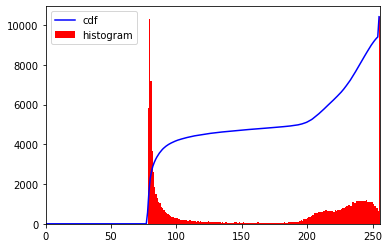

In [ ]:
# Histogram equalization
from google.colab.patches import cv2_imshow
image = cv2.imread(df["Files"][0],0)

hist,bins = np.histogram(image.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(image.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

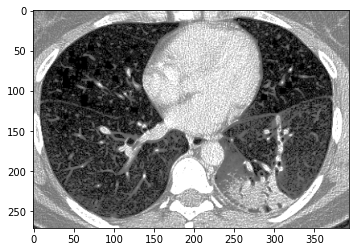

In [ ]:
dst = cv2.equalizeHist(image)
plt.imshow(dst, cmap="gray", vmin=0, vmax=255)

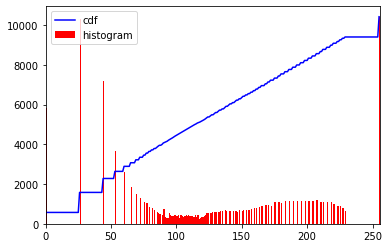

In [ ]:
hist,bins = np.histogram(dst.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(dst.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

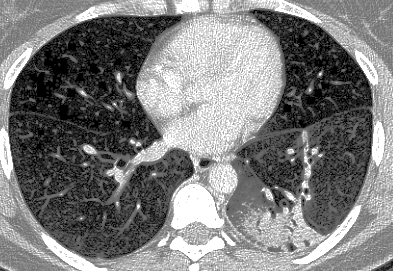

In [ ]:
# Histogram equalization
from google.colab.patches import cv2_imshow
image = cv2.imread(df["Files"][0],0)
dst = cv2.equalizeHist(image)
cv2_imshow(dst)

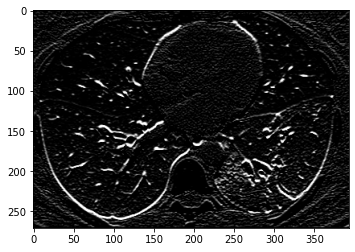

In [ ]:
# Convolution
img = cv2.imread(df["Files"][0])
filter_matrix = np.array([[-1,-2,-1], [0,0,0], [1, 2, 1]])
dst = cv2.filter2D(img,-1, filter_matrix)
plt.imshow(dst)

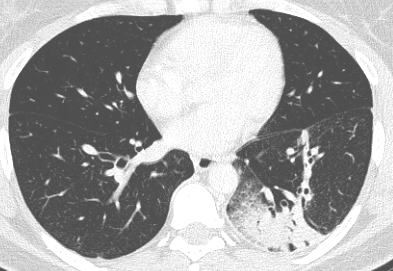

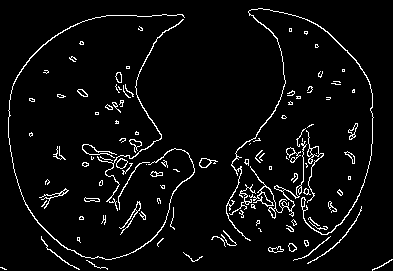

In [ ]:
# Edge Detection
import cv2
from google.colab.patches import cv2_imshow

#n = len(Files)
for i in range(1):
  img = cv2.imread(df['Files'][i]) 
  cv2_imshow(img)

  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img_blur = cv2.GaussianBlur(img_gray, (3,3), 0) 

  edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200)
  cv2_imshow(edges)

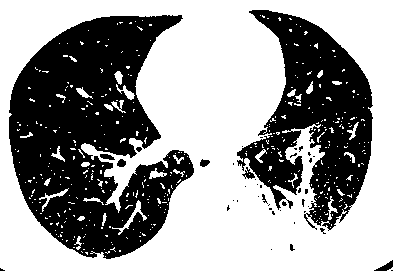

In [ ]:
img = cv2.imread(df["Files"][0])
ret, thresh_image = cv2.threshold(img,100,255,cv2.THRESH_BINARY)
cv2_imshow(thresh_image)

#Image Feature Extraction#
using gabor filters, GLCM and LBP

In [ ]:
label = []
featLength = 2+5+2
trainFeats = np.zeros((len(df),featLength)) #Feature vector of each image is of size 1x1030
for index in tqdm.tqdm_notebook(range(len(df))):
    img = PIL.Image.open(df["Files"][index]) #One image at a time
    img = img.resize((IMAGE_SIZE[0],IMAGE_SIZE[1]))
    img_gray = img.convert('L') #Converting to grayscale
    img_arr = np.array(img_gray.getdata()).reshape(img.size[1],img.size[0]) #Converting to array
    # LBP
    feat_lbp = local_binary_pattern(img_arr,5,2,'uniform').reshape(img.size[0]*img.size[1])
    lbp_hist,_ = np.histogram(feat_lbp,8)
    lbp_hist = np.array(lbp_hist,dtype=float)
    lbp_prob = np.divide(lbp_hist,np.sum(lbp_hist))
    lbp_energy = np.nansum(lbp_prob**2)
    lbp_entropy = -np.nansum(np.multiply(lbp_prob,np.log2(lbp_prob)))   
    # GLCM
    gCoMat = greycomatrix(img_arr, [2], [0],256,symmetric=True, normed=True)
    contrast = greycoprops(gCoMat, prop='contrast')
    dissimilarity = greycoprops(gCoMat, prop='dissimilarity')
    homogeneity = greycoprops(gCoMat, prop='homogeneity')    
    energy = greycoprops(gCoMat, prop='energy')
    correlation = greycoprops(gCoMat, prop='correlation')    
    feat_glcm = np.array([contrast[0][0],dissimilarity[0][0],homogeneity[0][0],energy[0][0],correlation[0][0]])
    # Gabor filter
    gaborFilt_real,gaborFilt_imag = gabor(img_arr,frequency=0.6)
    gaborFilt = (gaborFilt_real**2+gaborFilt_imag**2)//2
    gabor_hist,_ = np.histogram(gaborFilt,8)
    gabor_hist = np.array(gabor_hist,dtype=float)
    gabor_prob = np.divide(gabor_hist,np.sum(gabor_hist))
    gabor_energy = np.nansum(gabor_prob**2)
    gabor_entropy = -np.nansum(np.multiply(gabor_prob,np.log2(gabor_prob)))
    # Concatenating features(2+5+2)    
    concat_feat = np.concatenate(([lbp_energy,lbp_entropy],feat_glcm,[gabor_energy,gabor_entropy]),axis=0)
    trainFeats[index,:] = concat_feat #Stacking features vectors for each image
    # Class label
    label.append(df["Lables"][index])
trainLabel = np.array(label) #Conversion from list to array

#Normalizing Dataset#

In [ ]:
# Normalizing the train features to the range [0,1]
trMaxs = np.amax(trainFeats,axis=0) #Finding maximum along each column
trMins = np.amin(trainFeats,axis=0) #Finding maximum along each column
trMaxs_rep = np.tile(trMaxs,(2481,1)) #Repeating the maximum value along the rows
trMins_rep = np.tile(trMins,(2481,1)) #Repeating the minimum value along the rows
trainFeatsNorm = np.divide(trainFeats-trMins_rep,trMaxs_rep) #Element-wise division
# Normalizing the test features
tsMaxs_rep = np.tile(trMaxs,(10000,1)) #Repeating the maximum value along the rows
tsMins_rep = np.tile(trMins,(10000,1)) #Repeating the maximum value along the rows
testFeatsNorm = np.divide(testFeats-tsMins_rep,tsMaxs_rep) #Element-wise division

#Saving Features and their Lables in a pickle(.pckl) file#

In [ ]:
with open("trainFeats.pckl", "wb") as f:
    pickle.dump(trainFeatsNorm, f)
with open("trainLabel.pckl", "wb") as f:
    pickle.dump(trainLabel, f)
    
# Saving normalized testing data and labels
with open("testFeats.pckl", "wb") as f:
    pickle.dump(testFeatsNorm, f)
with open("testLabel.pckl", "wb") as f:
    pickle.dump(testLabel, f)
    
print('Files saved to disk!')

#Loading Pickle file with features#

In [ ]:
X = pd.read_pickle('https://github.com/M2kishore/Covid_Detection_using_CT_scans_ML/blob/M2kishore-dataset-with-file-lable/covidFeatures.pckl?raw=true')
Y = pd.read_pickle('https://github.com/M2kishore/Covid_Detection_using_CT_scans_ML/blob/M2kishore-dataset-with-file-lable/covidLable.pckl?raw=true')
X = pd.DataFrame(X,columns=['lbp_energy','lbp_entropy','glcm_contrast','glcm_dissimilarity','glcm_homogeniety','glcm_energy','glcm_correlation','gabor_energy','gabor_entropy'])
Y = pd.DataFrame(Y,columns=['labels'])

#EDA#

Joining X and Y for visualization and for removing outliers

The whole dataset along with features and label.

In [ ]:
full_df = pd.concat([X, Y], axis=1, join='inner')
full_df

,lbp_energy,lbp_entropy,glcm_contrast,glcm_dissimilarity,glcm_homogeniety,glcm_energy,glcm_correlation,gabor_energy,gabor_entropy,labels
0,0.017236,0.121773,0.597870,0.513895,0.191802,0.085669,0.125242,0.581479,0.183241,covid
1,0.017855,0.121603,0.569720,0.518874,0.201516,0.092408,0.128233,0.538920,0.234313,covid
2,0.046370,0.110524,0.689119,0.498859,0.400674,0.359581,0.135698,0.635952,0.114182,covid
3,0.051455,0.109109,0.558264,0.468588,0.286645,0.205200,0.125049,0.447744,0.336196,covid
4,0.024237,0.118902,0.446452,0.422259,0.226039,0.108830,0.142114,0.500625,0.266753,covid
...,...,...,...,...,...,...,...,...,...,...
2476,0.031167,0.115401,0.244261,0.272163,0.229921,0.042889,0.167897,0.064549,0.784422,noncovid
2477,0.017233,0.121130,0.423711,0.381658,0.197987,0.047983,0.145512,0.285188,0.481251,noncovid
2478,0.025492,0.117827,0.249155,0.307600,0.166571,0.027613,0.163933,0.108378,0.704244,noncovid
2479,0.035711,0.115105,0.783499,0.605124,0.294652,0.278465,0.115712,0.637454,0.119204,noncovid


In [ ]:
full_df.shape

(2481, 10)

In [ ]:
full_df.describe()

,lbp_energy,lbp_entropy,glcm_contrast,glcm_dissimilarity,glcm_homogeniety,glcm_energy,glcm_correlation,gabor_energy,gabor_entropy
count,2481.000000,2481.000000,2481.000000,2481.000000,2481.000000,2481.000000,2481.000000,2481.000000,2481.000000
mean,0.034759,0.114636,0.388441,0.395101,0.188948,0.077458,0.141179,0.344346,0.423530
std,0.035321,0.013147,0.162715,0.128567,0.109970,0.116110,0.026312,0.196343,0.212973
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.015058,0.111484,0.267495,0.297408,0.093801,0.024707,0.124546,0.184941,0.231287
50%,0.023771,0.118716,0.368059,0.378649,0.192657,0.043157,0.144234,0.276503,0.478561
75%,0.040867,0.122519,0.510659,0.503541,0.243293,0.066072,0.160660,0.539042,0.570605
max,0.405936,0.129115,0.922104,0.708385,0.863191,0.963041,0.199809,0.702465,0.936856


In [ ]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2481 entries, 0 to 2480
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   lbp_energy          2481 non-null   float64
 1   lbp_entropy         2481 non-null   float64
 2   glcm_contrast       2481 non-null   float64
 3   glcm_dissimilarity  2481 non-null   float64
 4   glcm_homogeniety    2481 non-null   float64
 5   glcm_energy         2481 non-null   float64
 6   glcm_correlation    2481 non-null   float64
 7   gabor_energy        2481 non-null   float64
 8   gabor_entropy       2481 non-null   float64
 9   labels              2481 non-null   object 
dtypes: float64(9), object(1)
memory usage: 194.0+ KB


In [ ]:
full_df.isnull().sum()

lbp_energy            0
lbp_entropy           0
glcm_contrast         0
glcm_dissimilarity    0
glcm_homogeniety      0
glcm_energy           0
glcm_correlation      0
gabor_energy          0
gabor_entropy         0
labels                0
dtype: int64

In [ ]:
full_df['labels'].value_counts()

covid       1252
noncovid    1229
Name: labels, dtype: int64

### **Visualization**


<Figure size 576x576 with 0 Axes>

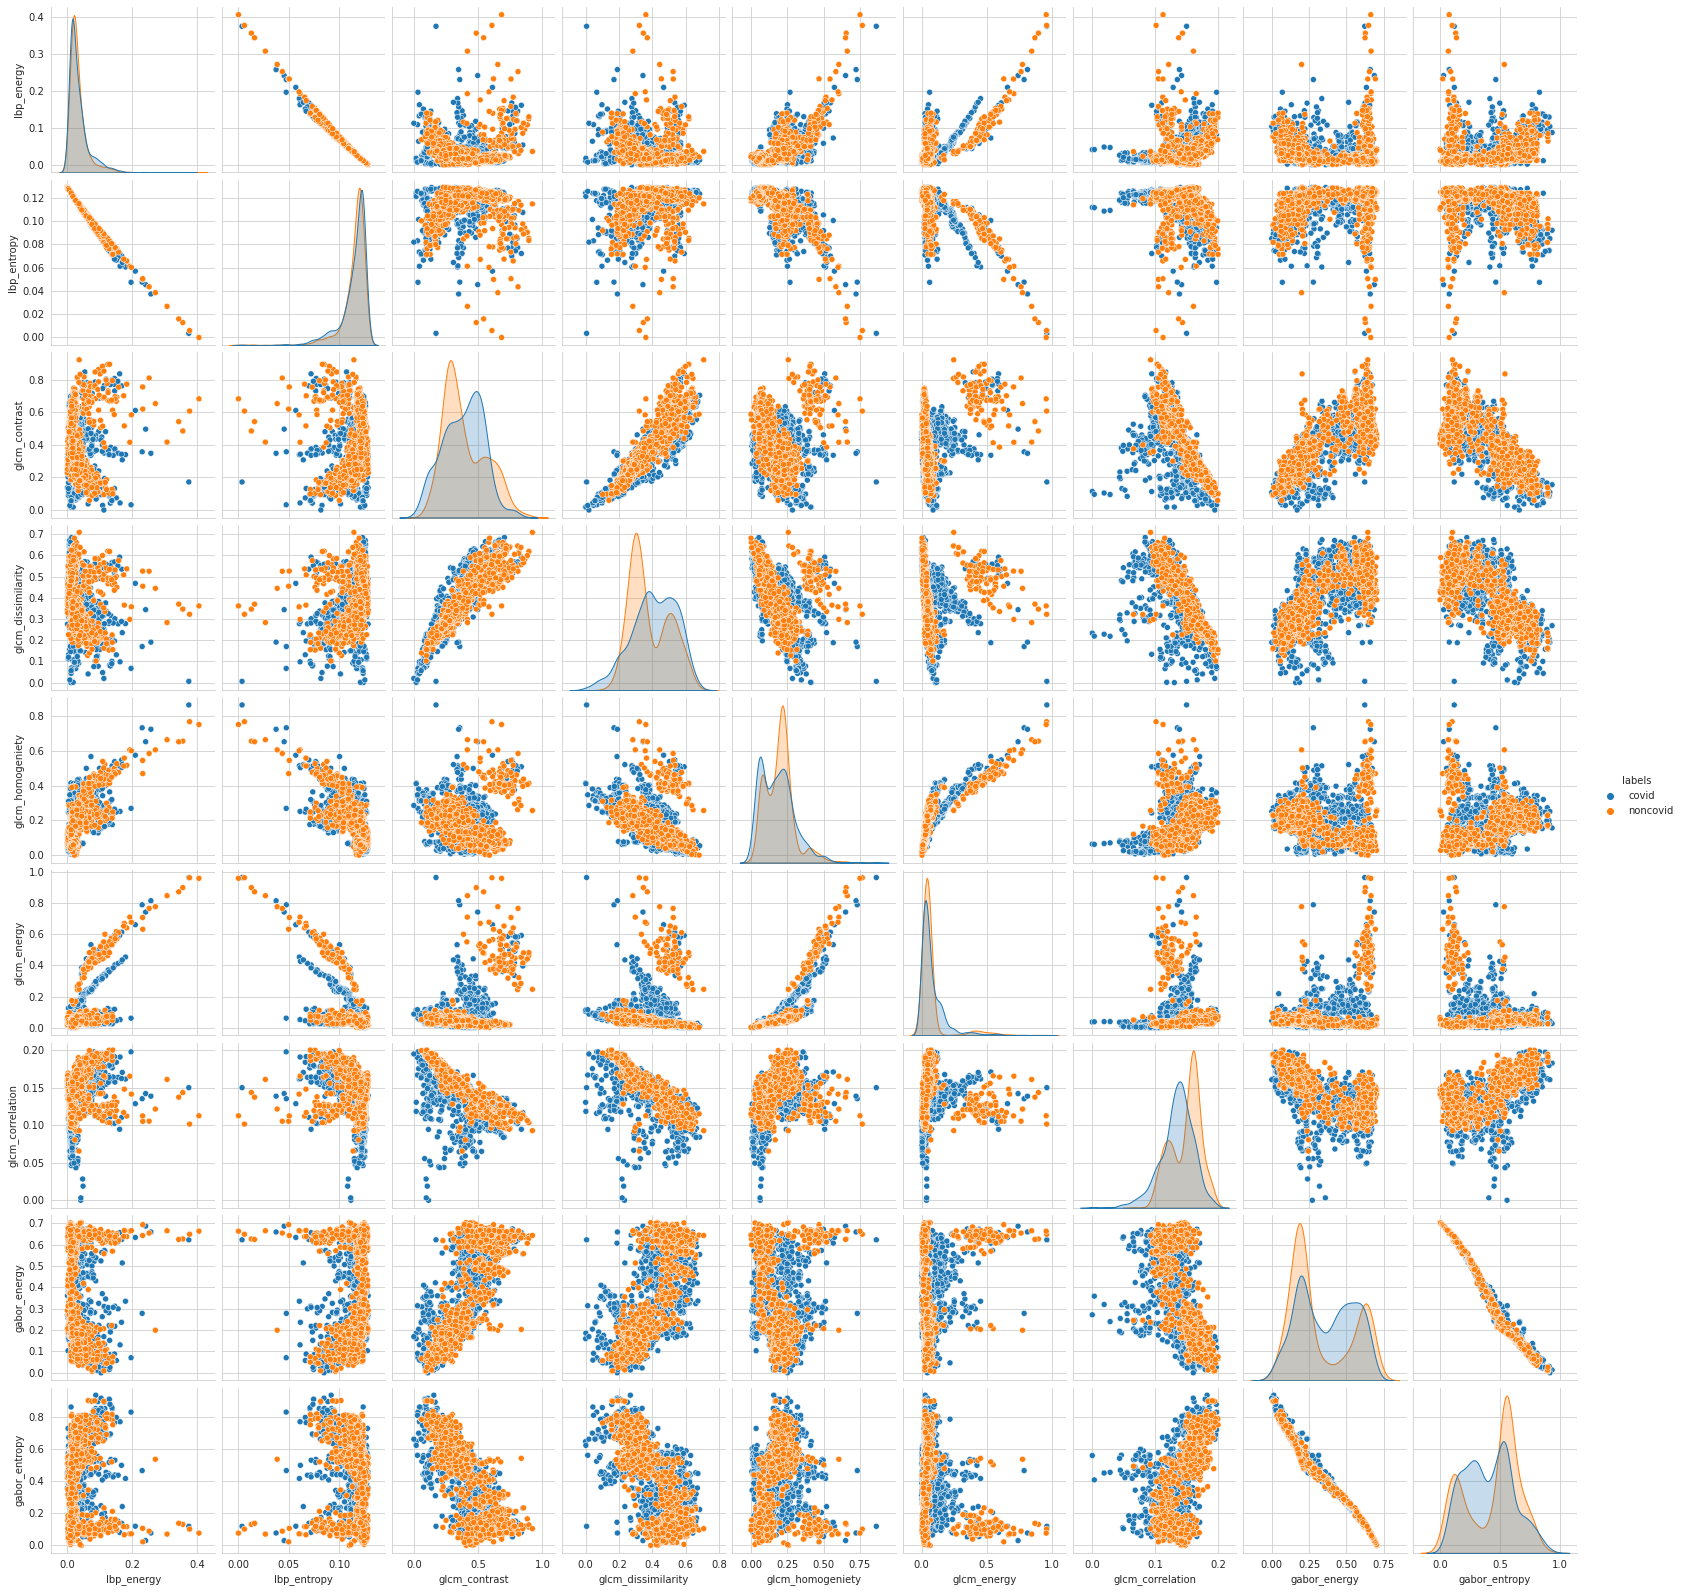

In [ ]:
plt.figure(figsize=(8,8))
sns.set_style("whitegrid")
sns.pairplot(full_df,hue="labels")
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
full_df['labels']= label_encoder.fit_transform(full_df['labels'])
sample_df = full_df.sample(frac=1,random_state=42)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


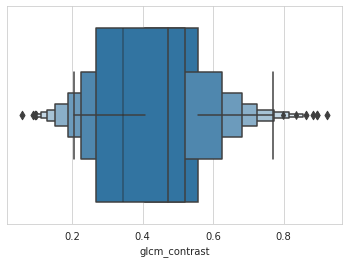

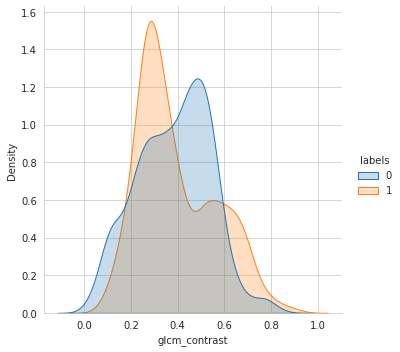

In [ ]:
groupbylabel = full_df.groupby('labels')
covid_df = groupbylabel.get_group(0)
non_covid_df = groupbylabel.get_group(1)
sns.boxplot(covid_df['glcm_contrast'].head(100))
sns.boxenplot(non_covid_df['glcm_contrast'])
sns.displot(full_df, x="glcm_contrast", kind="kde", hue='labels',fill=True)
#sns.pairplot(sample_df.head(100))

In [ ]:
full_df['labels'].value_counts()

0    1252
1    1229
Name: labels, dtype: int64

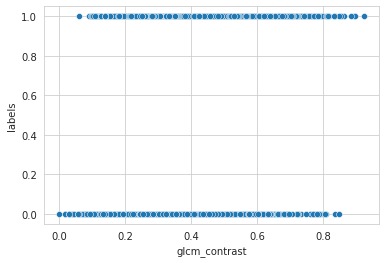

In [ ]:
sns.scatterplot(x=full_df['glcm_contrast'], y=full_df['labels'])
plt.show()

In [ ]:
X.var()

lbp_energy            0.001248
lbp_entropy           0.000173
glcm_contrast         0.026476
glcm_dissimilarity    0.016530
glcm_homogeniety      0.012093
glcm_energy           0.013481
glcm_correlation      0.000692
gabor_energy          0.038551
gabor_entropy         0.045358
dtype: float64

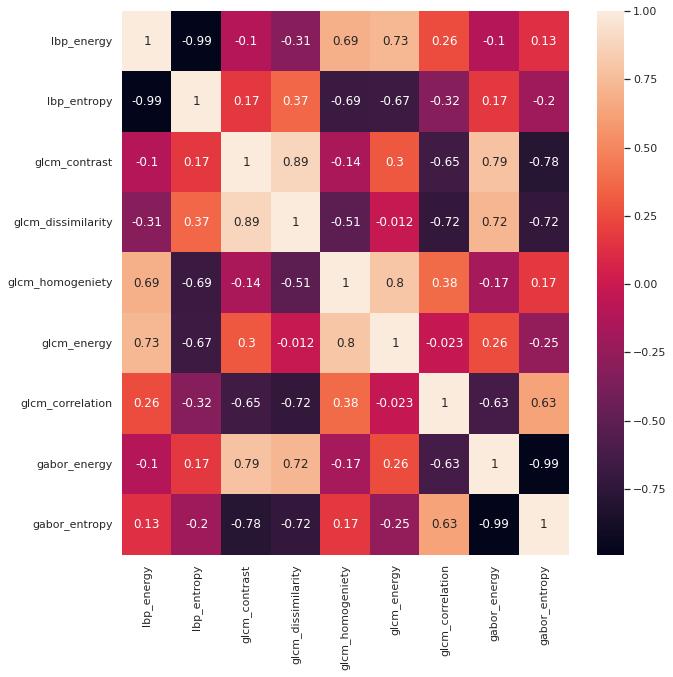

In [ ]:
sns.set(rc = {'figure.figsize':(10,10)})
sns.heatmap(X.corr(), annot = True)

## Dropping features<br>
* gabor entropy and energy are highly correlated<br>
* LBP energy and entropy are highly correlated

In [ ]:
X = X.drop('gabor_energy', axis = 1)
X = X.drop('lbp_entropy', axis = 1)

In [ ]:
X.head()

,lbp_energy,glcm_contrast,glcm_dissimilarity,glcm_homogeniety,glcm_energy,glcm_correlation,gabor_entropy
0,0.017236,0.597870,0.513895,0.191802,0.085669,0.125242,0.183241
1,0.017855,0.569720,0.518874,0.201516,0.092408,0.128233,0.234313
2,0.046370,0.689119,0.498859,0.400674,0.359581,0.135698,0.114182
3,0.051455,0.558264,0.468588,0.286645,0.205200,0.125049,0.336196
4,0.024237,0.446452,0.422259,0.226039,0.108830,0.142114,0.266753


#Train & Test#

Sampling and Randomize Testing

In [ ]:
X = X.sample(frac=1,random_state=42)
Y = Y.sample(frac=1,random_state=42)

Lable Encoding Y

In [ ]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
Y['labels']= label_encoder.fit_transform(Y['labels']) 

Dataset Splitting

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

Helper Function(s)

In [ ]:
def predictionBinarizer(y_predict,threshold =0.5):
  y_predict = y_predict.ravel()
  for i in range(len(y_predict)):
    if y_predict[i] >= threshold:
      y_predict[i] = 1
    else:
      y_predict[i] = 0
  return y_predict

Using Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=1)
model.fit(X_train,Y_train)

Y_predict = model.predict(X_test)

Y_predict = predictionBinarizer(Y_predict)

acc = accuracy_score(Y_test, Y_predict) * 100
print('Accuracy: %.3f' % acc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Accuracy: 89.135


Logistic regression using Contrast only

In [ ]:
X_train_contrast = X_train['glcm_contrast'].values.reshape(-1,1)
X_test_contrast = X_test['glcm_contrast'].values.reshape(-1,1)

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train_contrast,Y_train)

Y_predict = model.predict(X_test_contrast)

Y_predict = predictionBinarizer(Y_predict)

acc = accuracy_score(Y_test, Y_predict) * 100
print('Accuracy: %.3f ' % acc)

Accuracy: 43.461 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic regression using all the features

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train,Y_train)

Y_predict = model.predict(X_test)

Y_predict = predictionBinarizer(Y_predict)

acc = accuracy_score(Y_test, Y_predict) * 100
print('Accuracy: %.3f ' % acc)

Accuracy: 72.032 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
